In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import folium
from sklearn.cluster import DBSCAN
from shapely.geometry import Point, Polygon

## Load Data

In [4]:
# import all the data from the csv file
station_csv = pd.read_csv(os.path.join("../data/Task2/station_locations.csv"))
incident_csv = pd.read_csv(os.path.join("../data/Task2/wmfs_incidents.csv"))
mobilisation_csv = pd.read_csv(os.path.join("../data/Task2/wmfs_mobilisations.csv"))

## Data Cleaning

In [6]:

# rename the columns for the station_csv
station_csv.columns=['Station name', 'Sta_Easting', 'Sta_Northing', 'PRL_Count', 'BRV_Count', 'Closed (Y/N)', 'Opened', 'Closed']
station_csv.sample(5)

# create new columns for the mobilisation_csv, to get the time of the day, the day of the week and the month, from the 'call_time' of the mobilisation
mobilisation_csv['call_time'] = pd.to_datetime(mobilisation_csv['call_time'])
mobilisation_csv['call_hour'] = mobilisation_csv['call_time'].dt.hour
mobilisation_csv['call_day'] = mobilisation_csv['call_time'].dt.dayofweek
mobilisation_csv['call_month'] = mobilisation_csv['call_time'].dt.month
mobilisation_csv['call_year'] = mobilisation_csv['call_time'].dt.year
mobilisation_csv.sample(5)

# create new columns for the incident_csv, to get the time of the day, the day of the week and the month, from the 'call_time' of the incident
incident_csv['call_time'] = pd.to_datetime(incident_csv['call_time'])
incident_csv['call_hour'] = incident_csv['call_time'].dt.hour
incident_csv['call_day'] = incident_csv['call_time'].dt.dayofweek
incident_csv['call_month'] = incident_csv['call_time'].dt.month
incident_csv['call_year'] = incident_csv['call_time'].dt.year
incident_csv.sample(5)

# join the station_csv to the mobilisation_csv, by the 'Station name' column in station_csv and 'callsign_station' in mobilisation_csv
mobilisation_csv = mobilisation_csv.merge(station_csv, left_on='callsign_station', right_on='Station name', how='left')
mobilisation_csv.sample(5)


,Incident_Number,callsign_type,call_time,callsign_station,initial_incident_type,incident_classification_label,incident_profile_label,incident_classification_level1,call_seconds,reaction_seconds,...,Opened_x,Closed_x,Station name_y,Sta_Easting_y,Sta_Northing_y,PRL_Count_y,BRV_Count_y,Closed (Y/N)_y,Opened_y,Closed_y
178387,154102,BRV,2014-04-06 19:01:20,Binley,OPEN,Deliberate Rubbish Fires,Low Risk,FIRE,102,119,...,Before study period,NaN,Binley,436876.0,278691.0,1.0,1.0,N,Before study period,NaN
136865,124868,PRL,2013-01-20 10:26:06,Kings Norton,RTC,Road Traffic Collision,High Risk,RTC,43,108,...,Before study period,NaN,Kings Norton,404865.0,279690.0,1.0,0.0,N,Before study period,NaN
545520,412241,BRV,2024-01-27 20:31:47,Oldbury,ALARMS SLEEPING NON MANAGED,False Alarms (Equipment),Low Risk,FALSE_ALARM,68,60,...,Before study period,NaN,Oldbury,399022.0,288393.0,1.0,1.0,N,Before study period,NaN
464168,356989,PRL,2022-02-25 00:53:23,Hay Mills,RTC,Road Traffic Collision,High Risk,RTC,223,137,...,Before study period,NaN,Hay Mills,411478.0,284683.0,1.0,1.0,N,Before study period,NaN
5433,31810,PRL,2010-02-13 11:20:57,Foleshill,MOTORWAY VEHICLE FIRE,False alarm raised with good intent,False Alarms,FALSE_ALARM,141,108,...,Before study period,NaN,Foleshill,434545.0,282370.0,1.0,1.0,N,Before study period,NaN


## Voronoi Diagram

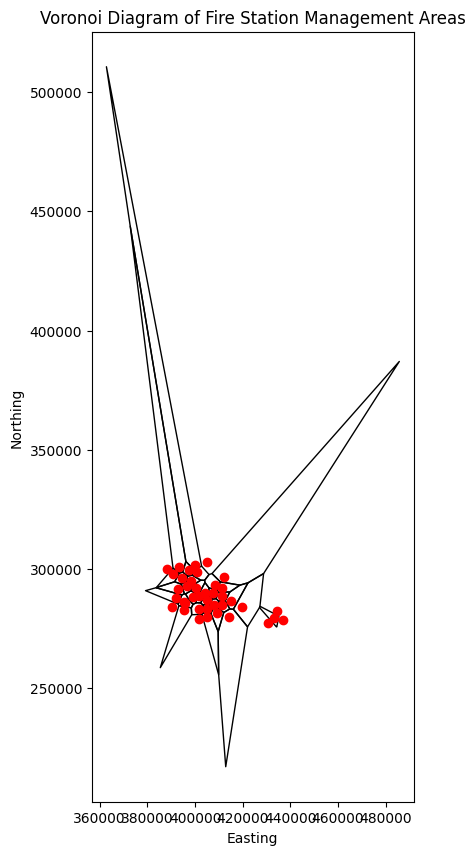

In [12]:
# Load station locations
station_locations_path = '../data/Task2/station_locations.csv'
station_locations = pd.read_csv(station_locations_path)

# Create a GeoDataFrame with station locations
geometry = [Point(xy) for xy in zip(station_locations['Easting'], station_locations['Northing'])]
gdf_stations = gpd.GeoDataFrame(station_locations, geometry=geometry)

# Generate Voronoi diagram
points = station_locations[['Easting', 'Northing']].values
vor = Voronoi(points)

# Create Voronoi polygons
voronoi_regions = []
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        polygon = Polygon([vor.vertices[i] for i in region])
        voronoi_regions.append(polygon)

# Create a GeoDataFrame with Voronoi polygons
gdf_voronoi = gpd.GeoDataFrame(geometry=voronoi_regions)

# Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(10, 10))
gdf_voronoi.plot(ax=ax, edgecolor='black', facecolor='none')
gdf_stations.plot(ax=ax, color='red')
plt.title('Voronoi Diagram of Fire Station Management Areas')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()


## Station Location

In [14]:
west_midlands_gdf = gpd.read_file("../data/westmidslands/westmidlands.shp")

In [15]:
geometry = [Point(xy) for xy in zip(station_locations['Easting'], station_locations['Northing'])]

gdf = gpd.GeoDataFrame(station_locations, geometry=geometry)
gdf.set_crs(epsg=27700, inplace=True)
gdf = gdf.to_crs(epsg=4326)

gdf.explore(marker_kwds={'radius': 7})

Text(0.5, 1.0, 'West Midlands with Fire Stations')

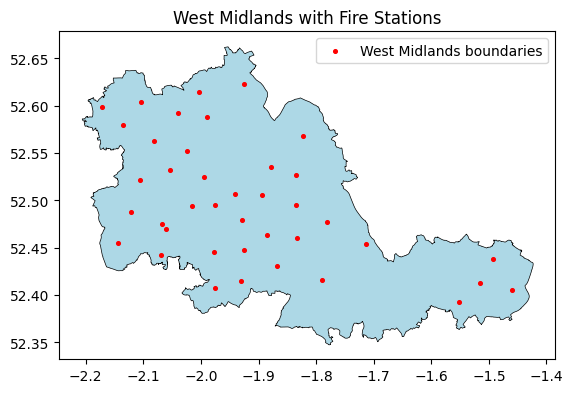

In [17]:
import geopandas as gpd

# Assuming station_locations is a DataFrame with 'Easting' and 'Northing' columns

west_midlands_gdf = gpd.read_file("../data/westmidslands/westmidlands.shp")

geometry = [Point(xy) for xy in zip(station_csv['Sta_Easting'], station_csv['Sta_Northing'])]
station_points_gdf = gpd.GeoDataFrame(station_csv, geometry=geometry)

# Set CRS for station points
station_points_gdf.set_crs(epsg=27700, inplace=True)

# Reproject both station points and West Midlands data to WGS84 (epsg=4326)
station_points_gdf_wgs84 = station_points_gdf.to_crs(epsg=4326)
west_midlands_gdf_wgs84 = west_midlands_gdf.to_crs(epsg=4326)

# Plot both layers
ax = west_midlands_gdf_wgs84.plot(color='lightblue', edgecolor='black', linewidth=0.5)
station_points_gdf_wgs84.plot(ax=ax, marker='o', markersize=7, color='red')

# Add legend and title
ax.legend(['West Midlands boundaries', 'Fire Stations'])
ax.set_title('West Midlands with Fire Stations')



## Cluster

In [18]:
# 获取 incident_classification_label 列的唯一值
unique_labels = mobilisation_csv['incident_classification_label'].unique()

# 打印唯一值
print(unique_labels)

['False alarm raised with good intent' 'Road Traffic Collision'
 'False Alarms (Equipment)' 'False alarm raised with malicious intent'
 'Accidental rubbish fire' 'Advice Only' 'Deliberate Rubbish Fires'
 'Making Safe (not RTC)' 'Deliberate Vehicle Fires' 'Deliberate FDR Other'
 'Accidental Dwelling Fires' 'Lock in / lock out (effecting entry / exit)'
 'Secondary fire resulting from deliberately set fire' 'Lift Release'
 'Accidental secondary fire'
 'Water incident (flooding, leaks, rescues etc.)'
 'Transport incident (Not RTC)' 'Removal of objects from people'
 'Accidental fire in a vehicle' 'Accidental Non-Domestic Fires'
 'Special Service Call - Service not required.'
 'Other rescue/release of persons' 'Deliberate Non-Domestic Fires'
 'First Aid' 'Deliberate Dwelling Fires' 'Gas leak'
 'Hazardous Materials incident' 'Deliberate Derelict Vehicle'
 'Spillage of non hazardous substance' 'Assist other agencies'
 'Deliberate Derelict Building Fires' 'Other Standby'
 'Animal rescue / assis

In [14]:
# 获取唯一值
unique_labels = mobilisation_csv['incident_profile_label'].unique()

# 打印唯一值
print(unique_labels)

['False Alarms' 'High Risk' 'Low Risk' 'Medium Risk'
 'Secondary Fires that attract a 20 minute-response time']


In [43]:
# 获取唯一值
unique_labels = mobilisation_csv['incident_classification_level1'].unique()

# 打印唯一值
print(unique_labels)

['FALSE_ALARM' 'RTC' 'FIRE' 'SSC' 'OTHER' 'FALLS_RESPONSE']


## False Alarms(Equipment) DBSCAN

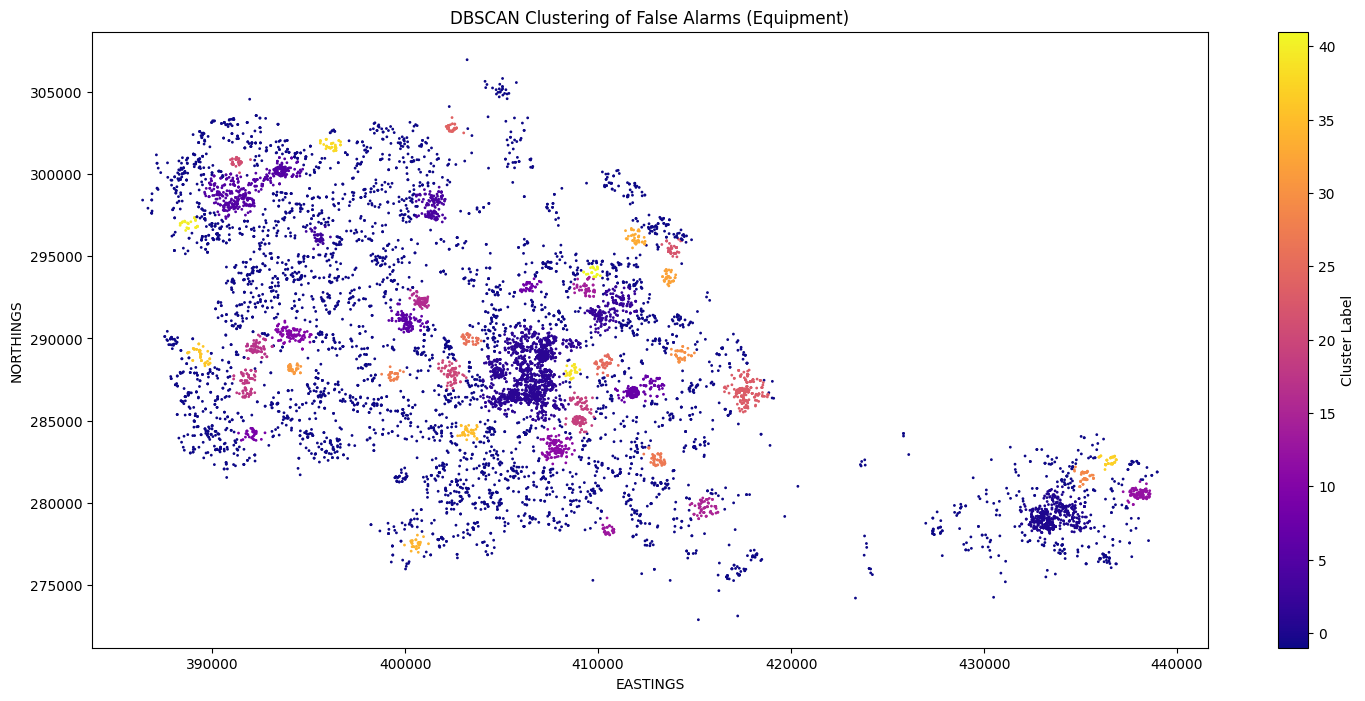

             EASTINGS      NORTHINGS  Cluster
501370  415613.796686  287073.097780       -1
501371  396500.212445  292170.069076       -1
501378  389784.606222  295772.172932       -1
501379  389784.606222  295772.172932       -1
501380  389784.606222  295772.172932       -1


In [19]:
# Convert call_time to datetime format
mobilisation_csv['call_time'] = pd.to_datetime(mobilisation_csv['call_time'], errors='coerce')

# Filter the data for the year 2023
mobilisation_2023 = mobilisation_csv[mobilisation_csv['call_time'].dt.year == 2023]


# Filter the data for 'False Alarms (Equipment)'
filtered_data = mobilisation_2023[mobilisation_2023['incident_classification_label'] == 'False Alarms (Equipment)']

# Extract the EASTINGS and NORTHINGS columns
coordinates = filtered_data[['EASTINGS', 'NORTHINGS']].dropna()

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=500, min_samples=30)
dbscan.fit(coordinates)

# Add the cluster labels to the data
coordinates['Cluster'] = dbscan.labels_

# Plot the clusters
plt.figure(figsize=(18, 8))
plt.scatter(coordinates['EASTINGS'], coordinates['NORTHINGS'], c=coordinates['Cluster'], cmap='plasma', marker='o', s=1)
plt.title('DBSCAN Clustering of False Alarms (Equipment)')
plt.xlabel('EASTINGS')
plt.ylabel('NORTHINGS')
plt.colorbar(label='Cluster Label')
plt.show()

# Display the result
print(coordinates.head())

## Hour Change

C:\Users\W\AppData\Local\Temp\ipykernel_10260\3073077637.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the layout to make room for the legend


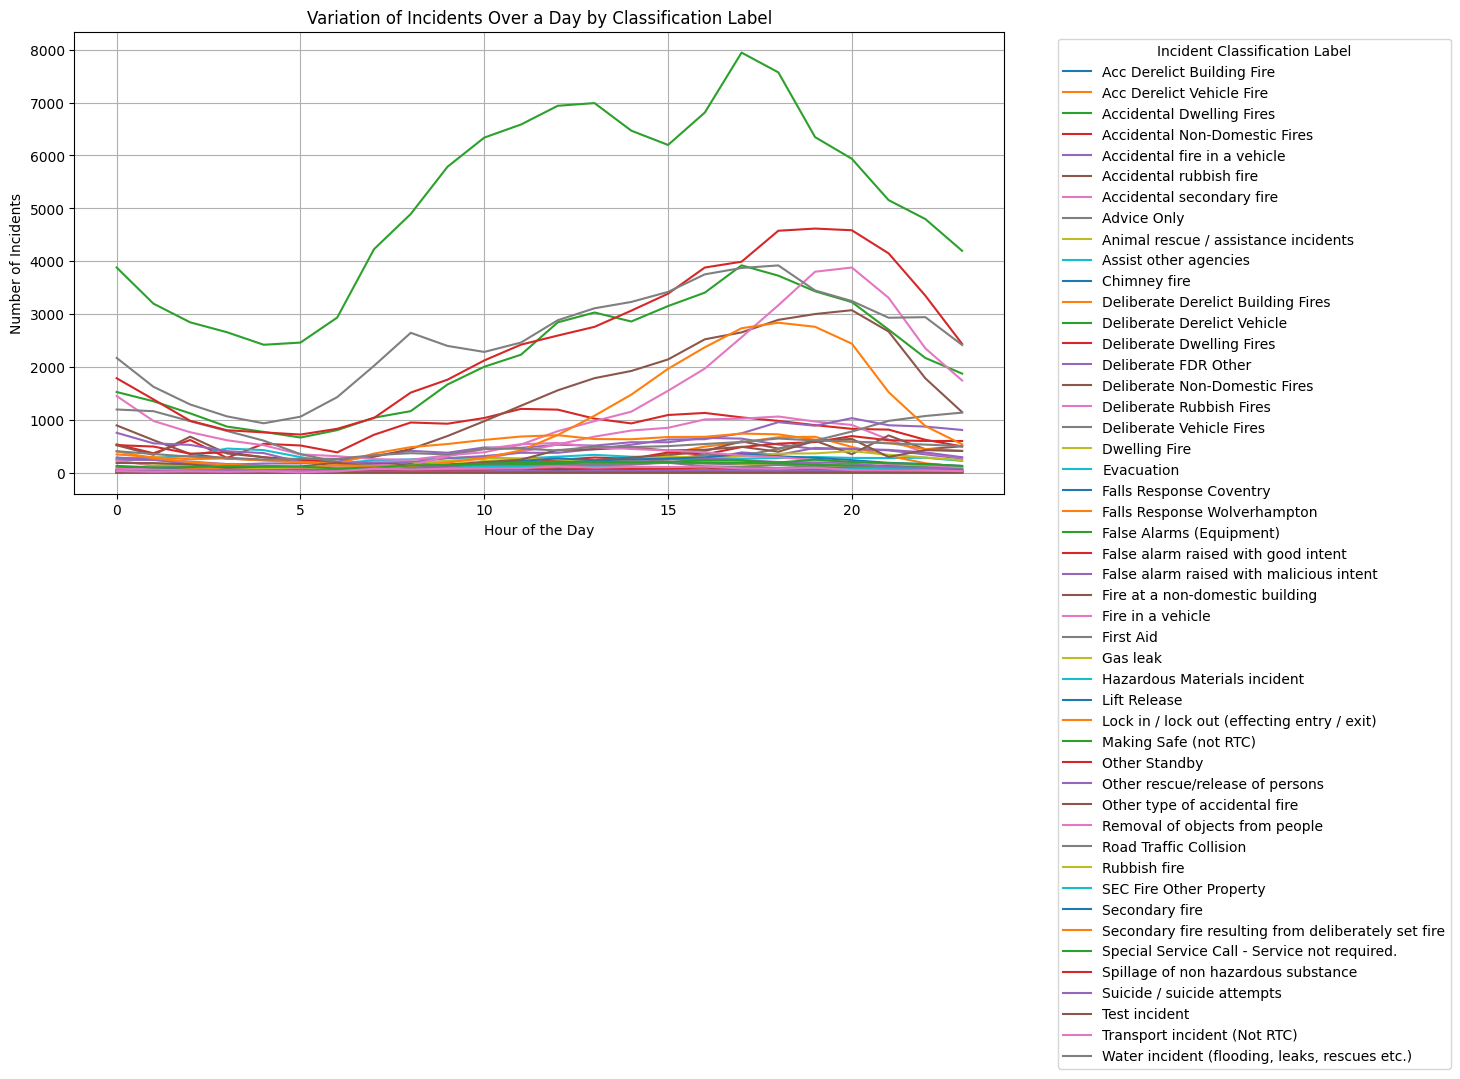

In [20]:

# Group by hour and incident_classification_label, then count occurrences
hourly_data = mobilisation_csv.groupby(['call_hour', 'incident_classification_label']).size().reset_index(name='count')

# Pivot the data to have hours as rows and incident_classification_label as columns
pivot_data = hourly_data.pivot(index='call_hour', columns='incident_classification_label', values='count').fillna(0)

# Plot the data
plt.figure(figsize=(12, 6))
for label in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[label], label=label)

plt.title('Variation of Incidents Over a Day by Classification Label')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.legend(title='Incident Classification Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

C:\Users\W\AppData\Local\Temp\ipykernel_10260\1552540048.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the layout to make room for the legend


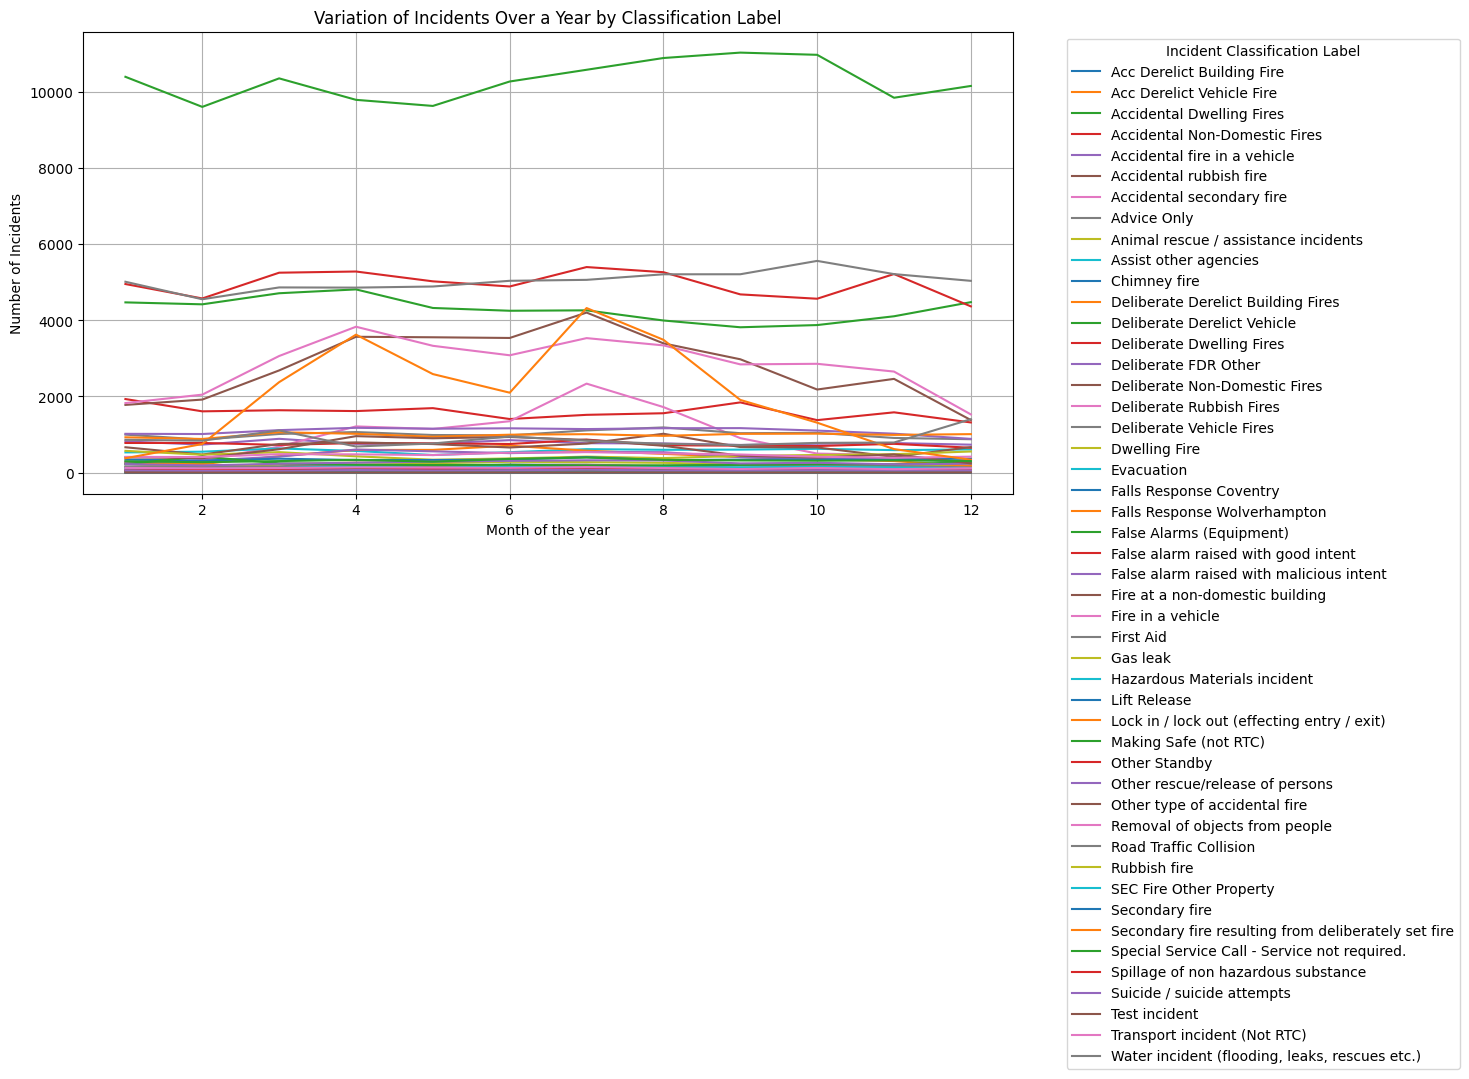

In [21]:

# Group by hour and incident_classification_label, then count occurrences
hourly_data = mobilisation_csv.groupby(['call_month', 'incident_classification_label']).size().reset_index(name='count')

# Pivot the data to have hours as rows and incident_classification_label as columns
pivot_data = hourly_data.pivot(index='call_month', columns='incident_classification_label', values='count').fillna(0)

# Plot the data
plt.figure(figsize=(12, 6))
for label in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[label], label=label)

plt.title('Variation of Incidents Over a Year by Classification Label')
plt.xlabel('Month of the year')
plt.ylabel('Number of Incidents')
plt.legend(title='Incident Classification Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()